In [100]:
import matplotlib.pyplot as plt
import numpy as np
import os
from datetime import datetime
import pandas as pd
from analysis_functions import *
import uncertainties.unumpy as unp
from uncertainties import ufloat

In [101]:
results_folder_path = "/Users/colinweaver/Documents/PTTEP/Results/"

data_300K_run4_path = "09.16/run_1_08h37"

data_300K_run2 = "/Users/colinweaver/Documents/PTTEP/Results/09.22/run_1_10h39"
data_300K_run1 = "/Users/colinweaver/Documents/PTTEP/Results/09.10/run_1_08h30"
data_300K_run3 = "/Users/colinweaver/Documents/PTTEP/Results/09.11/run_1_09h38"
data_300K_run4 = results_folder_path + data_300K_run4_path

temperature_C = 500 # temperature in Celsius
e = 0.00088 # sample thickness in meters measured

temperature_K = temperature_C + 273.15
R = 8.314 # J/(mol*K)
V = ufloat(7.9e-5, 9.8e-6) # m^3, volume of downstream chamber
d_sample = 0.0155 # diameter of fitting on sample in meters
Area = 1/4 * np.pi * (d_sample)**2 # m^2

In [102]:
# Load data
t, df = load_downstream_data(data_300K_run4 + "/pressure_gauge_data.csv")

V_Baratron_downstream = df["Baratron626D_1T_Voltage_V"].to_numpy(dtype=float)
V_Wasp_downstream = df["WGM701_Voltage_V"].to_numpy(dtype=float)
V_Baratron_upstream = df["Baratron626D_1KT_Voltage_V"].to_numpy(dtype=float)
V_Wasp_upstream = df["CVM211_Voltage_V"].to_numpy(dtype=float)

t_0 = 0

P_Wasp_downstream = voltage_to_torr_wasp_downstream(V_Wasp_downstream)
P_Baratron_upstream = voltage_to_torr_baratron(V_Baratron_upstream)

P_up = average_pressure_after_increase(t, P_Baratron_upstream)  # convert Torr to Pa


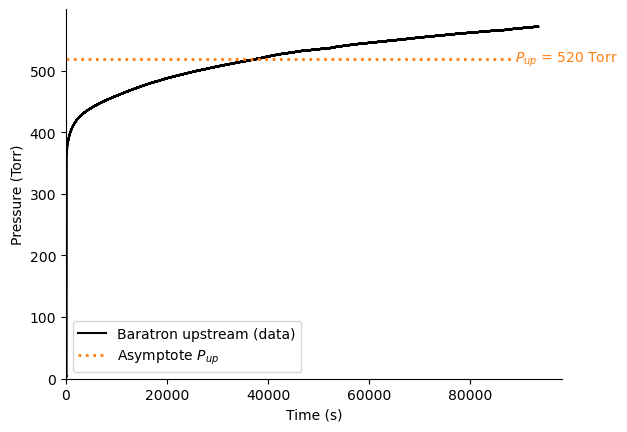

In [103]:
plt.figure()
ax = plt.gca()

# Plot upstream Baratron pressure data
ax.plot(t, P_Baratron_upstream, color="black", linewidth=1.5, label="Baratron upstream (data)")

# Draw horizontal asymptote at P_up
ax.hlines(P_up, xmin=float(t[0]), xmax=float(t[-1]),
          linestyles=":", linewidth=2, color="C1", label="Asymptote $P_{up}$")

# Annotate the P_up value on the right-hand side
x_annot = t[-1] - 0.05 * (t[-1] - t[0])  # slightly inset from right edge
ax.text(x_annot, P_up,
        f"$P_{{up}}$ = {P_up:.3g} Torr",
        va="center", ha="left",
        bbox=dict(boxstyle="round,pad=0.25", fc="white", ec="none", alpha=0.8),
        color="C1")

# Style axes
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Torr)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.legend()

# Save or show
# plt.savefig("baratron_upstream_asymptote.png", dpi=300, bbox_inches="tight")
plt.show()

[0.0000000e+00 1.3100000e-01 2.5600000e-01 ... 9.3418692e+04 9.3418804e+04
 9.3418916e+04]
[1.52305110e-05 1.52526837e-05 1.52194367e-05 ... 4.41147958e-01
 4.40186365e-01 4.40827194e-01]
asymptote x-intercept: 38119.61542204166


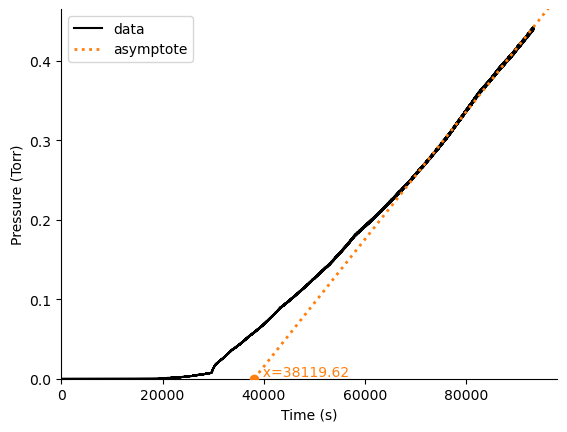

In [104]:
plt.figure()
ax = plt.gca()
ax.plot(t, P_Wasp_downstream, color="black", label="data")
ax.set_xlabel("Time (s)")
ax.set_ylabel("Pressure (Torr)")
ax.set_xlim(left=0)
ax.set_ylim(bottom=0)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

print(t)
print(P_Wasp_downstream)

# Fit asymptote and plot as dotted line down to its x-axis crossing

slope, intercept, start_idx = fit_linear_asymptote(t, P_Wasp_downstream)
# compute x where asymptote crosses y=0: 0 = slope*x + intercept
if abs(slope) < 1e-12:
    # slope too small to find a meaningful intercept
    raise ValueError("slope too small")
x_cross = -intercept / slope
print(f"asymptote x-intercept: {x_cross}")

# draw asymptote from its x-intercept up to the end of the data
x_span = t[-1] - t[0] if t[-1] != t[0] else 1.0
x_end = t[-1] + 0.2 * x_span
x_start = x_cross
# ensure we create an array in increasing order for plotting
if x_start <= x_end:
    x_ext = np.linspace(x_start, x_end, 2)
else:
    x_ext = np.linspace(x_end, x_start, 2)
y_ext = slope * x_ext + intercept
ax.plot(x_ext, y_ext, linestyle=":", color="C1", linewidth=2, label="asymptote")

# mark crossing on the x-axis and annotate
if np.isfinite(x_cross):
    ax.scatter([x_cross], [0], color="C1", zorder=5)
    ax.text(x_cross, 0, f"  x={x_cross:.2f}", va="bottom", color="C1")
ax.legend()


plt.show()

# plt.savefig("asymptote_fit.png", dpi=300, bbox_inches="tight")


In [105]:
# Using timelag to calculate D_eff
tau_l = x_cross - t_0
D_eff = e**2 / (6 * tau_l)
phi_timelag = slope*133.3 / (R*temperature_K/V*(P_up*133.3)**0.5*e*Area) * 6.022*10**23

print(f"Effective diffusion coefficient: D_eff = {D_eff:.2e} m^2/s")
print(f"Permeability from timelag: phi = {phi_timelag:.2e} mol/(m·s·Pa^0.5)")

print(slope *3600)

Effective diffusion coefficient: D_eff = 3.39e-12 m^2/s
Permeability from timelag: phi = (1.81+/-0.22)e+17 mol/(m·s·Pa^0.5)
0.028827948271925932


In [106]:
# Using Flux to calculate permeability

dPdt = slope * 133.3 # convert Torr/s to Pa/s
J = dPdt*V / (R*temperature_K*Area) * 6.022*10**23 # H/(m^2*s)

Perm = J*e / (P_up*133.3)**0.5

print(f"Permeability (continuum calculation): Phi = {Perm:.2e}")

Permeability (continuum calculation): Phi = (1.40+/-0.17)e+11


In [107]:
# Takaishi-Sensui approximation for the Thermal Transpiration Effect correction

V1_ratio = ufloat(0.35, 0.1) # ratio of V1 to total volume

V1 = V*V1_ratio
V2 = V*(1-V1_ratio)
T1 = temperature_K
T2 = 300 # ambient temperature in Kelvin

A  = 1.24 * 56.3 / 10e-5
B  = 8 * 7.7 / 10e-2
C  = 10.6 * 2.73
d = 0.0155 # diameter of pipe

P2dot = dPdt
P2 = P_Wasp_downstream[-1] * 133.3 # convert Torr to Pa


# --- helper quantities ---
num2 = C*(d*P2)**0.5 + (T2/T1)**0.5 + A*d**2*P2**2 + B*d*P2     # #2
den3 = C*(d*P2)**0.5 + A*d**2*P2**2 + B*d*P2 + 1                # #3

num1 = B*d*P2dot + (C*d*P2dot)/(2*(d*P2)**0.5) + 2*A*d**2*P2*P2dot  # #1

# --- assemble dn/dt ---
n_dot = (V2*P2dot)/(R*T2) \
      + (V1*P2dot)/(R*T1*num2) \
      + (V1*P2*num1)/(R*T1*num2*den3) \
      - (V1*P2*num1)/(R*T1*num2**2)

J_TS = n_dot / Area * 6.022*10**23 # H/(m^2*s)

Perm_TS = J_TS*e / (P_up*133.3)**0.5 # Permeability from Takaishi-Sensui
print(f"Permeability from Takaishi-Sensui: Phi_TS = {Perm_TS:.2e}")

Permeability from Takaishi-Sensui: Phi_TS = (2.35+/-0.46)e+11


In [108]:
# free molecular flow approximation for the Thermal Transpiration Effect correction

dndt = dPdt * (V1/(R*(T2*T1)**0.5) + V2/(R*T2)) # dn/dt from free molecular flow approx

J_FMF = dndt / Area * 6.022*10**23 # H/(m^2*s)

Perm_FMF = J_FMF*e / (P_up*133.3)**0.5 # Permeability from Takaishi-Sensui

print(f"Permeability from Free Molecular Flow: Phi_FMF = {Perm_FMF:.2e}")

Permeability from Free Molecular Flow: Phi_FMF = (3.13+/-0.41)e+11


In [109]:
Ps = [Perm, Perm_TS, Perm_TS + (Perm_TS - Perm)]

vals = np.array([x.n for x in Ps])
errs = np.array([x.s for x in Ps])

weights = 1 / errs**2
mean_val = np.sum(weights * vals) / np.sum(weights)
mean_std = np.sqrt(1 / np.sum(weights))

Ps_combined = ufloat(mean_val, mean_std)
print(Ps_combined)

(1.58+/-0.16)e+11


In [110]:
import csv

# Fill in
material = "316l_steel" # same format as htm


outdir = "results/figs"
os.makedirs(outdir, exist_ok=True)   # Create folders if not exist
csv_filename = os.path.join(outdir, f"{material}_diffusivities.csv")

write_run_to_csv(csv_filename, data_300K_run4_path, material, temperature_K, D_eff, Perm_TS)